## Pitch Analysis

### Members:

### 1. Atharva Saney (23PGAI0069)

### 2. Rohan Mehta (23PGAI0001)

In [ ]:
## installing dependencies if any of them are missing

!pip install tqdm basic_pitch librosa pyaudio sounddevice

In [6]:
## importing necessary libraries

import pyaudio
import time
from scipy.io import wavfile
from scipy import signal
import numpy as np
from tqdm import tqdm
import librosa
import math
import matplotlib.pyplot as plt
from basic_pitch.inference import predict
from basic_pitch import ICASSP_2022_MODEL_PATH
import pretty_midi
import sounddevice as sd
import numpy as np
import scipy.fftpack
import os

## Detecting pitch for audio file

Here we will create functions that will take an audio file, and do pitch analysis for that file. To do pitch analysis on any specific audio file, just change the path variable audio_file_path.

In [7]:
audio_file_path = 'CantinaBand3.wav'

## this is the input function that will be input for test function
## it is an audio waveform with pitch of 1 Hz

def f(x):
    f_0 = 1
    envelope = lambda x: np.exp(-x)
    return np.sin(x * np.pi * 2 * f_0) * envelope(x)

## we need to caluclate auto correlation function to get the differnce

def ACF(f, W, t, lag):
    try:
        return np.sum(
        f[t : t + W] * f[lag + t : lag + t + W])
    except:
        pass


## we can use square of the differnce to get rid of negatives. 
## Moreover, it would be beneficial to express the squared difference in terms of ACF
## so we can write a corresponding function for that

def DF(f, W, t, lag):
    return ACF(f, W, t, 0) \
            + ACF(f, W, t + lag, 0) \
            - (2 * ACF(f, W, t, lag))

# cumulative mean normalized difference
def CMNDF(f, W, t, lag):
    if lag == 0:
        return 1
    return DF(f, W, t, lag) / np.sum([DF(f, W, t, j + 1) for j in range(lag)]) * lag

## this is the main function used to detect pitch

def detect_pitch(f, W, t, sample_rate, bounds, thresh = 0.1):
    CMNDF_vals = [CMNDF(f, W, t, i) for i in range(*bounds)]
    sample = None
    
    for i, val in enumerate(CMNDF_vals):
        if val < thresh:
            sample = i + bounds[0]
            break
    if sample is None:
        sample = np.argmin(CMNDF_vals) + bounds[0]
        
    return sample_rate / sample


def test():
    sample_rate = 500
    start = 0
    end = 5
    num_samples = int(sample_rate * (end - start) + 1)
    window_size = 200
    bounds = [20, num_samples // 2]
    
    x = np.linspace(start, end, num_samples)
    print(f'detected pitch: {detect_pitch(f(x), window_size, 1, sample_rate, bounds)} Hz')

In [8]:
%%time

## first we will feed in a sample input, to check if the code is working

test()

detected pitch: 1.002004008016032 Hz
CPU times: total: 8.47 s
Wall time: 8.57 s


## Detecting pitch for live data

Here you can run the function and play audio of your choice into the mic, this code will detect the pitch live.

**Approach 1**

We will calculate and print the frequencies (pitches), just like we did before with the test audio. After you are done, press ENTER to view the historical graph of all previous pitches in that session.

**Approach 2**

The main intention to predict or calculate pitch, is to check the octave of specific notes. All musical notes have a specific frequency range in that specific ovtave. We have included a master table for the same, and we want to display the user those specific notes. Hence we have followed approach 2, which is again another method to calculate frequency, and convert them to specific notes, not only do we need to display notes, but also the octave.

to evaluate the working of our model, we have compared the same with Guitar tuner app which is one of the most accurate pitch measurement devices.

Detected Pitch: 763 Hz         
Detected Pitch: 565 Hz         

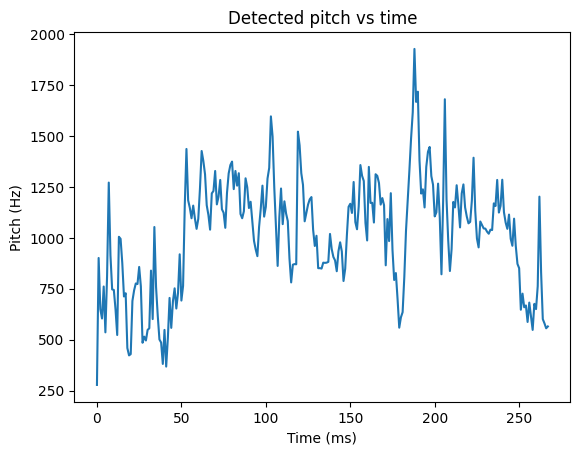

In [12]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 64000
CHUNK = 1024    # 1024

all_pitches = []

stream_buffer = []

p = pyaudio.PyAudio()

def empty_frame(length):
    """Returns an empty 16bit audio frame of supplied length."""
    frame = np.zeros(length, dtype='i2')
    return to_raw_data(frame)

def callback_in(in_data, frame_count, time_info, status):
    """Callback function for incoming data from an input stream."""
    stream_buffer.append(in_data)
    process(in_data)
    return (in_data, pyaudio.paContinue)

def callback_out(in_data, frame_count, time_info, status):
    """Callback function for outgoing data to an output stream."""
    try:
        data = stream_buffer.pop(0)
    except:
        data = empty_frame(frame_count)
    return (data, pyaudio.paContinue)

def to_int_data(raw_data):
    """Converts raw bytes data to ."""
    return np.array([int.from_bytes(raw_data[i:i+2], byteorder='little', signed=True) for i in range(0, len(raw_data), 2)])

def to_raw_data(int_data):
    data = int_data.clip(-32678, 32677)
    data = data.astype(np.dtype('i2'))
    return b''.join(data.astype(np.dtype('V2')))

def process(raw_data):
    st = time.time()
    data = to_int_data(raw_data)
    data = data*4		# raise volume
    detect_pitch(data)
    et = time.time()
    return to_raw_data(data)

def normal_distribution(w):
    width = w+1
    weights = np.exp(-np.square([2*x/width for x in range(width)]))
    weights = np.pad(weights, (width-1,0), 'reflect')
    weights = weights/np.sum(weights)
    return weights

def detect_pitch(int_data):
    if 'avg' not in detect_pitch.__dict__:
        detect_pitch.avg = 0
    WIND = 10
    CYCLE = 400
    weights = normal_distribution(WIND)
    windowed_data = np.pad(int_data, WIND, 'reflect')
    smooth_data = np.convolve(int_data, weights, mode='valid')
    smooth_pitches = [0]+[np.mean(smooth_data[:-delay] - smooth_data[delay:]) for delay in range(1,CYCLE)]

    dips = [x for x in range(WIND, CYCLE-WIND) if smooth_pitches[x] == np.min(smooth_pitches[x-WIND:x+WIND])]
    if len(dips) > 1:
        av_dip = np.mean(np.ediff1d(dips))
        cheq_freq = RATE / av_dip
        detect_pitch.avg = detect_pitch.avg*0.5 + cheq_freq*0.5
        all_pitches.append(int(detect_pitch.avg))
        print('\rDetected Pitch: '+str(int(detect_pitch.avg))+' Hz        ', end='')


if __name__ == "__main__":
    stream_in = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, stream_callback=callback_in)
    stream_out = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, output=True, stream_callback=callback_out)

    stream_in.start_stream()
    stream_out.start_stream()

    txt = input()	#stream until enter key press

    stream_in.stop_stream()
    stream_in.close()
    stream_out.stop_stream()
    stream_out.close()

    p.terminate()

    plt.plot(all_pitches)
    plt.xlabel('Time (ms)')
    plt.ylabel('Pitch (Hz)')
    plt.title('Detected pitch vs time')
    plt.show()

In [11]:
## Approach 2
## we will calculate a note every second, any change faster than that will not be captured
## if you want to capture if, you need to change the SAMPLE_FREQ
## a higher SAMPLE_FREQ will correspond to faster calculation

# General settings
SAMPLE_FREQ = 44100 # sample frequency in Hz
WINDOW_SIZE = 44100 # window size of the DFT in samples
WINDOW_STEP = 21050 # step size of window
WINDOW_T_LEN = WINDOW_SIZE / SAMPLE_FREQ # length of the window in seconds
SAMPLE_T_LENGTH = 1 / SAMPLE_FREQ # length between two samples in seconds
windowSamples = [0 for _ in range(WINDOW_SIZE)]

# This function finds the closest note for a given pitch
# Returns: note (e.g. A4, G#3, ..), pitch of the tone
CONCERT_PITCH = 440
ALL_NOTES = ["A","A#","B","C","C#","D","D#","E","F","F#","G","G#"]
def find_closest_note(pitch):
    i = int(np.round(np.log2(pitch/CONCERT_PITCH)*12))
    closest_note = ALL_NOTES[i%12] + str(4 + (i + 9) // 12)
    closest_pitch = CONCERT_PITCH*2**(i/12)
    return closest_note, closest_pitch

# The sounddecive callback function
# Provides us with new data once WINDOW_STEP samples have been fetched
def callback(indata, frames, time, status):
    global windowSamples
    if status:
        print(status)
    if any(indata):
        windowSamples = np.concatenate((windowSamples,indata[:, 0])) # append new samples
        windowSamples = windowSamples[len(indata[:, 0]):] # remove old samples
        magnitudeSpec = abs( scipy.fftpack.fft(windowSamples)[:len(windowSamples)//2] )

        for i in range(int(62/(SAMPLE_FREQ/WINDOW_SIZE))):
              magnitudeSpec[i] = 0 #suppress mains hum

        maxInd = np.argmax(magnitudeSpec)
        maxFreq = maxInd * (SAMPLE_FREQ/WINDOW_SIZE)
        closestNote, closestPitch = find_closest_note(maxFreq)

        os.system('cls' if os.name=='nt' else 'clear')
        print(f"Closest note: {closestNote}, max frequency: {maxFreq:.1f},  closest pitch: {closestPitch:.1f}")
    else:
        print('no input')

import sys

# Start the microphone input stream
try:
    with sd.InputStream(channels=1, callback=callback,
        blocksize=WINDOW_STEP,
        samplerate=SAMPLE_FREQ):
        while True:
            t = input()
            break
except Exception as e:
    print(str(e))

Closest note: F#3, max frequency: 185.0,  closest pitch: 185.0
Closest note: F#3, max frequency: 185.0,  closest pitch: 185.0
Closest note: A#5, max frequency: 953.0,  closest pitch: 932.3
Closest note: F6, max frequency: 1392.0,  closest pitch: 1396.9
Closest note: F6, max frequency: 1393.0,  closest pitch: 1396.9
Closest note: D6, max frequency: 1190.0,  closest pitch: 1174.7
Closest note: A5, max frequency: 878.0,  closest pitch: 880.0
Closest note: C6, max frequency: 1040.0,  closest pitch: 1046.5
Closest note: C6, max frequency: 1047.0,  closest pitch: 1046.5



## Detecting pitch using standard libraries

Here we will use basic-pitch library to detect pitch. For more information on the library refer: https://github.com/spotify/basic-pitch

This library uses deep learning to predict the pitch

In [36]:
model_output, midi_data, note_events = predict('CantinaBand3.wav')
model_output

Predicting MIDI for CantinaBand3.wav...


{'contour': array([[0.12747292, 0.09957641, 0.09814113, ..., 0.10240234, 0.0837875 ,
         0.1070776 ],
        [0.12726292, 0.10001253, 0.09772835, ..., 0.10539532, 0.08761113,
         0.10866801],
        [0.12722479, 0.10015807, 0.09714406, ..., 0.10287426, 0.08785017,
         0.10715754],
        ...,
        [0.09274735, 0.08341444, 0.09868293, ..., 0.10437474, 0.08582141,
         0.15232265],
        [0.09283369, 0.08504324, 0.09860569, ..., 0.10540222, 0.08795976,
         0.16192298],
        [0.09284732, 0.08695046, 0.09818973, ..., 0.10062294, 0.08828031,
         0.13847543]], dtype=float32),
 'note': array([[0.11603396, 0.09931272, 0.10048861, ..., 0.10310158, 0.10474327,
         0.10662778],
        [0.11603969, 0.09959069, 0.10020691, ..., 0.10300893, 0.10441104,
         0.10696567],
        [0.11603568, 0.09996271, 0.09984739, ..., 0.10290199, 0.10409098,
         0.10727966],
        ...,
        [0.11072019, 0.09746922, 0.09699234, ..., 0.09445094, 0.10007014,


In [37]:
# Load MIDI file
print(midi_data)
print('\n\n')
print(dir(midi_data))




['_PrettyMIDI__tick_to_time', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_load_instruments', '_load_metadata', '_load_tempo_changes', '_tick_scales', '_update_tick_to_time', 'adjust_times', 'estimate_beat_start', 'estimate_tempi', 'estimate_tempo', 'fluidsynth', 'get_beats', 'get_chroma', 'get_downbeats', 'get_end_time', 'get_onsets', 'get_piano_roll', 'get_pitch_class_histogram', 'get_pitch_class_transition_matrix', 'get_tempo_changes', 'instruments', 'key_signature_changes', 'lyrics', 'remove_invalid_notes', 'resolution', 'synthesize', 'text_events', 'tick_to_time', 'time_signature_changes', 'time_to_tick', 'write']


In [38]:
note_events

[(2.7644585034013605,
  2.938608163265306,
  57,
  0.5421,
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 (2.694798639455782,
  2.834118367346939,
  65,
  0.57105356,
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 (2.555478911564626,
  2.7644585034013605,
  57,
  0.44644818,
  [1, 1, 1, 1, 1, 1, -2, -2, -2, -2, -2, 1, 1, 1, 1, 1, 1, 1]),
 (2.5206489795918365,
  2.7760684807256233,
  38,
  0.6263036,
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (2.4858190476190476,
  2.694798639455782,
  65,
  0.52879876,
  [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1]),
 (2.0794698412698414,
  2.2420095238095237,
  45,
  0.45244017,
  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]),
 (2.009809977324263,
  2.1723496598639453,
  57,
  0.56280357,
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]),
 (1.9040362811791383,
  2.0794698412698414,
  69,
  0.47787696,
  [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 (1.9040362811791383,
  2.0794698412698414,
  45,
  0.39724675,
  [